<a href="https://colab.research.google.com/github/abhinavmishragsv-analytics/Post-Covid-Health-Effects-Analysis/blob/main/Post_Covid_Health_Effects_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score
from sklearn.metrics import precision_recall_curve
import joblib

#Reading the dataset and checking if there are any missing values

df=pd.read_csv('post_covid_health_effects_dataset.csv')
print(display(df.head()))
print("Shape of the data",df.shape)
df['Age']=df['Age'].fillna("")
df['Gender']=df['Gender'].fillna("")
df['COVID_Severity']=df['COVID_Severity'].fillna("")
df['Hospitalized']=df['Hospitalized'].fillna("")
df['Days_to_Recovery']=df['Days_to_Recovery'].fillna("")
df['Fatigue_Level']=df['Fatigue_Level'].fillna("")
df['Brain_Fog']=df['Brain_Fog'].fillna("")
df['Breathing_Issue']=df['Breathing_Issue'].fillna("")
df['Loss_of_Taste_Smell']=df['Loss_of_Taste_Smell'].fillna("")
df['Long_COVID_Risk']=df['Long_COVID_Risk'].fillna("")
df['Physical_Activity_Level']=df['Physical_Activity_Level'].fillna("")
df['Mental_Health_Impact']=df['Mental_Health_Impact'].fillna("")
print("There are no missing values in the data")

#Data Cleaning

df=df.drop_duplicates()

#Now we convert the values of our target column(Brain_Fog) to binary

df['Brain_Fog'] = df['Brain_Fog'].map({'Yes': 1, 'No': 0})

#Now we separate the features and the the target column

x=df_features=df.drop('Brain_Fog',axis=1)
y=df['Brain_Fog']

#train-test-split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

#now we identify the columns which have categories

categorical_cols=x.select_dtypes(include=['object']).columns
numerical_cols=x.select_dtypes(exclude=['object']).columns

#preprocessing of the data

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

categorical_cols = x.select_dtypes(include=['object']).columns
numeric_cols = x.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__C': [0.01, 0.1, 0.5, 1, 2, 5, 10]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc'
)

grid.fit(x_train, y_train)

print("Best C:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

best_model = grid.best_estimator_

feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()
coefficients = best_model.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(coef_df.head(10))

y_prob = best_model.predict_proba(x_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

for p, r, t in zip(precision, recall, thresholds):
    if r >= 0.80:
        optimal_threshold = t
        break

print("Optimal Threshold:", optimal_threshold)

y_pred_custom = (y_prob >= optimal_threshold).astype(int)

#model

model=LogisticRegression(
    class_weight='balanced',
    max_iter=2000)

#pipeline

pipeline=Pipeline(steps=[('preprocessing',preprocessor),('classifier',model)])

#train model

pipeline.fit(x_train,y_train)

#predictions

y_pred=pipeline.predict(x_test)
y_prob=pipeline.predict_proba(x_test)[:,-1]

#evaluation

print("Accuracy Score",accuracy_score(y_test,y_pred))
print("\nConfusion Matrix",confusion_matrix(y_test,y_pred))
print("\nClassification Report",classification_report(y_test,y_pred))
print("\nROC AUC Score",roc_auc_score(y_test,y_prob))

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Find threshold where recall >= 0.80
for p, r, t in zip(precision, recall, thresholds):
    if r >= 0.80:
        optimal_threshold = t
        break

print("Optimal Threshold:", optimal_threshold)

# Apply custom threshold
y_pred_custom = (y_prob >= optimal_threshold).astype(int)

print("\nConfusion Matrix (Custom Threshold):")
print(confusion_matrix(y_test, y_pred_custom))


#now we save the model

joblib.dump(pipeline,"brain_fog_model.pkl")

,Age,Gender,COVID_Severity,Hospitalized,Days_to_Recovery,Fatigue_Level,Breathing_Issue,Brain_Fog,Loss_of_Taste_Smell,Physical_Activity_Level,Mental_Health_Impact,Long_COVID_Risk
0,56,Female,Mild,No,175,4,No,No,No,Low,5,High
1,69,Female,Severe,No,128,4,No,Yes,No,Medium,5,Medium
2,46,Female,Mild,Yes,125,1,Yes,No,No,High,2,Low
3,32,Female,Mild,No,120,1,No,Yes,No,Low,3,Low
4,60,Male,Moderate,No,16,3,No,No,Yes,Medium,5,Low


None
Shape of the data (500, 12)
There are no missing values in the data
Best C: {'classifier__C': 1}
Best CV ROC-AUC: 0.604805148116192
                                Feature  Coefficient
2                     cat__Gender_Other     0.787711
15            cat__Long_COVID_Risk_High     0.361532
3              cat__COVID_Severity_Mild     0.356041
14  cat__Physical_Activity_Level_Medium     0.313639
21            num__Mental_Health_Impact     0.264817
6                  cat__Hospitalized_No     0.120195
10          cat__Loss_of_Taste_Smell_No     0.102451
8               cat__Breathing_Issue_No     0.099069
18                             num__Age     0.028392
5            cat__COVID_Severity_Severe     0.016223
Optimal Threshold: 0.16484069089151876
Accuracy Score 0.61

Confusion Matrix [[53 22]
 [17  8]]

Classification Report               precision    recall  f1-score   support

           0       0.76      0.71      0.73        75
           1       0.27      0.32      0.29        2

['brain_fog_model.pkl']

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


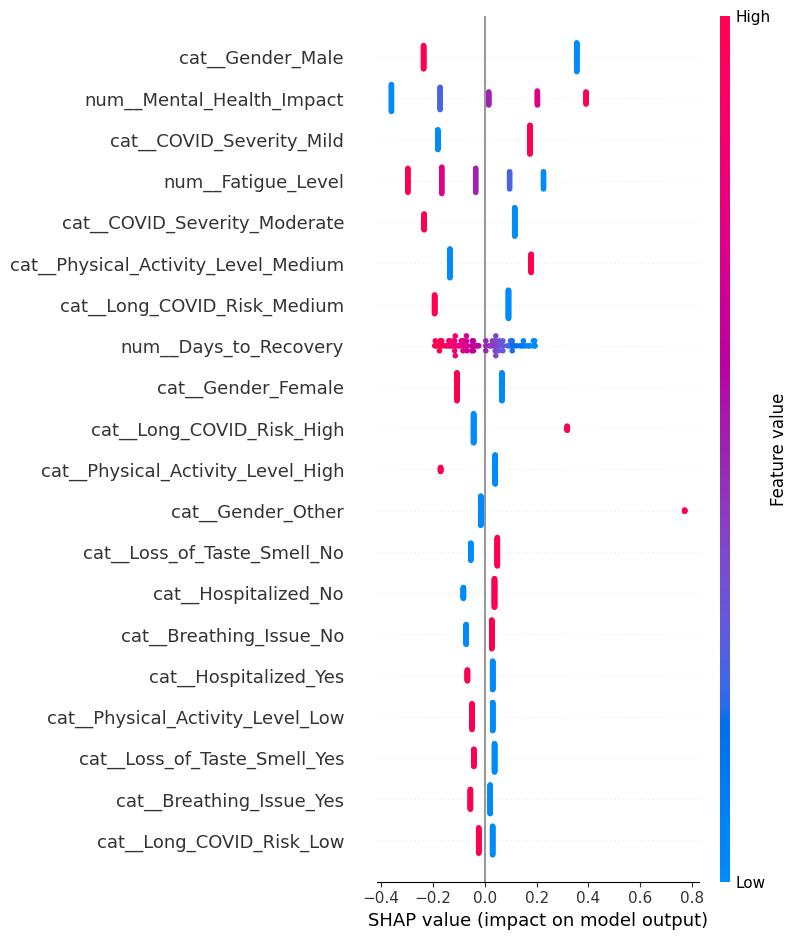

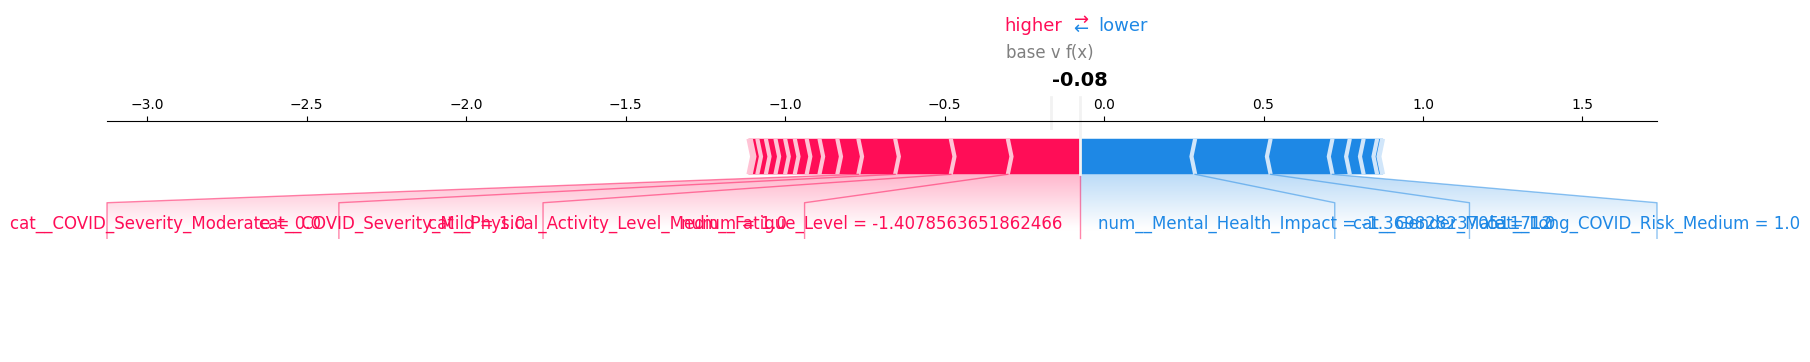

In [52]:
!pip install shap
import shap
import matplotlib.pyplot as plt
import random as rand
best_model=grid.best_estimator_
# now we get our preprocessor and classifier together
preprocessor=best_model.named_steps['preprocessing']
classifier=best_model.named_steps['classifier']
# now we transform the data into numerics for SHAP
x_train_transformed=preprocessor.transform(x_train)
x_test_transformed=preprocessor.transform(x_test)
#now we use SHAP to explain us the values with the help of Logistic Regression
explainer = shap.LinearExplainer(
    classifier,
    x_train_transformed,
    feature_perturbation="interventional"
)

shap_values = explainer.shap_values(x_test_transformed)
#plotting features
shap.summary_plot(
    shap_values,
    x_test_transformed,
    feature_names=feature_names
)

#explaining the causes to the patient
index = 0

shap.force_plot(
    explainer.expected_value,
    shap_values[index],
    x_test_transformed[index],
    feature_names=feature_names,
    matplotlib=True
)


Random Patient Index: 36
🧠 Brain Fog Risk Assessment Report
-----------------------------------
Predicted Risk Score: 19.42%
Risk Category: LOW

Recommended Action: Routine monitoring.


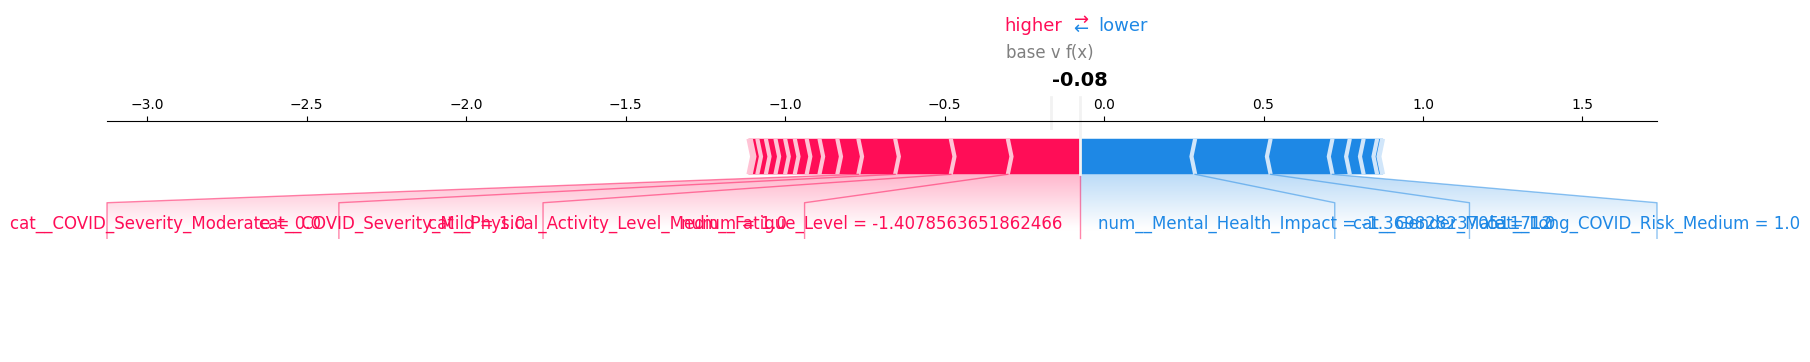

🧠 Brain Fog Risk Assessment Report
-----------------------------------
Predicted Risk Score: 48.12%
Risk Category: MODERATE

Recommended Action: Monitor cognitive symptoms for 2–4 weeks.
Min probability: 0.16484069089151876
Max probability: 0.8899176600415429
Mean probability: 0.44696075043907385
Std deviation: 0.14248957856105993


In [56]:
import random
def predict_brain_fog(patient_df, model, threshold=0.4):
    prob = model.predict_proba(patient_df)[:,1][0]
    risk_score = round(prob * 100, 2)

    # Risk category
    if risk_score < 30:
        category = "LOW"
    elif risk_score < 60:
        category = "MODERATE"
    else:
        category = "HIGH"

    print("🧠 Brain Fog Risk Assessment Report")
    print("-----------------------------------")
    print(f"Predicted Risk Score: {risk_score}%")
    print(f"Risk Category: {category}")

    if category == "LOW":
        print("\nRecommended Action: Routine monitoring.")
    elif category == "MODERATE":
        print("\nRecommended Action: Monitor cognitive symptoms for 2–4 weeks.")
    else:
        print("\nRecommended Action: Schedule early cognitive evaluation.")


rand_index = random.randint(0, len(x_test)-1)

print(f"Random Patient Index: {rand_index}")
predict_brain_fog(x_test.iloc[[rand_index]], best_model)

shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    x_test_transformed[0],
    feature_names=feature_names,
    matplotlib=True
)
predict_brain_fog(x_test.iloc[[0]], best_model, threshold=0.4)
# Get probabilities from test set
probs = best_model.predict_proba(x_test)[:, 1]

print("Min probability:", probs.min())
print("Max probability:", probs.max())
print("Mean probability:", probs.mean())
print("Std deviation:", probs.std())


In [58]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import pandas as pd
import shap
import random


# Create Input Widgets

categorical_cols = x.select_dtypes(include=['object']).columns
numeric_cols = x.select_dtypes(exclude=['object']).columns

widgets_dict = {}

# Categorical dropdowns
for col in categorical_cols:
    options = df[col].unique().tolist()
    widgets_dict[col] = widgets.Dropdown(
        options=options,
        description=col,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )

# Numeric sliders
for col in numeric_cols:
    widgets_dict[col] = widgets.FloatSlider(
        value=float(df[col].mean()),
        min=float(df[col].min()),
        max=float(df[col].max()),
        step=0.1,
        description=col,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='70%')
    )

predict_button = widgets.Button(
    description="🔍 Predict Brain Fog Risk",
    button_style='primary'
)

output = widgets.Output()

def on_predict_clicked(b):
    with output:
        clear_output()

        input_data = {col: widgets_dict[col].value for col in widgets_dict}
        input_df = pd.DataFrame([input_data])

        prob = best_model.predict_proba(input_df)[:,1][0]
        risk_score = round(prob * 100, 2)

        if risk_score < 30:
            category = "LOW"
            color = "#28a745"
        elif risk_score < 60:
            category = "MODERATE"
            color = "#ffc107"
        else:
            category = "HIGH"
            color = "#dc3545"

        # HTML Card
        display(HTML(f"""
        <div style="
            border-radius: 12px;
            padding: 20px;
            background-color: #f8f9fa;
            box-shadow: 2px 2px 10px rgba(0,0,0,0.1);
            width: 80%;
        ">
            <h2 style="color:#343a40;">🧠 Brain Fog Risk Assessment</h2>
            <hr>
            <h3>Risk Score:
                <span style="color:{color}; font-weight:bold;">
                    {risk_score}%
                </span>
            </h3>
            <h4>Risk Category:
                <span style="color:{color}; font-weight:bold;">
                    {category}
                </span>
            </h4>
            <br>
            <div style="background-color:#e9ecef; border-radius:20px;">
                <div style="
                    width:{risk_score}%;
                    background-color:{color};
                    padding:10px;
                    border-radius:20px;
                    color:white;
                    text-align:center;
                ">
                    {risk_score}%
                </div>
            </div>
            <br>
            <h4>📋 Recommended Action:</h4>
            <p>
        """))

        if category == "LOW":
            print("Routine monitoring recommended.")
        elif category == "MODERATE":
            print("Monitor cognitive symptoms over the next 2–4 weeks.")
        else:
            print("Schedule early cognitive evaluation and follow-up.")

        display(HTML("</p></div>"))

        # SHAP Explanation
        transformed_input = preprocessor.transform(input_df)

        shap_values_single = explainer.shap_values(transformed_input)

        print("\n🔎 Model Explanation (Feature Impact):")
        shap.force_plot(
            explainer.expected_value,
            shap_values_single[0],
            transformed_input[0],
            feature_names=feature_names,
            matplotlib=True
        )

predict_button.on_click(on_predict_clicked)

# Display Clean UI Layout


display(HTML("<h2 style='color:#2c3e50;'>🏥 NeuroRisk AI – Brain Fog Screening Tool</h2>"))
display(HTML("<p style='color:gray;'>Enter patient details below and click predict.</p>"))

display(widgets.VBox(list(widgets_dict.values())))
display(predict_button)
display(output)

Button(button_style='primary', description='🔍 Predict Brain Fog Risk', style=ButtonStyle())

Output()